In [4]:
import pandas as pd

def load_data(filepath):
    data = pd.read_csv(filepath, sep=",", header=None)
    data.columns = ["sepal_length", "sepal_width", 
                    "petal_length", "petal_width", 
                    "class"]
    return data

data = load_data("pset1/Iris_Data.txt")
print("{} data points loaded".format(len(data)))

150 data points loaded


## Plot Iris flower dataset

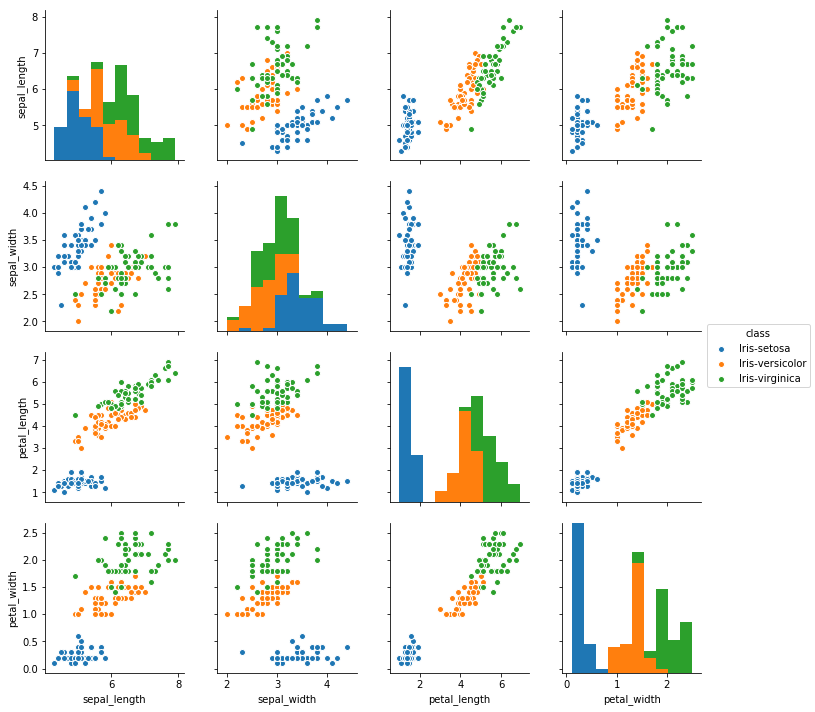

In [5]:
%matplotlib inline
import seaborn
seaborn.pairplot(data, hue='class')

## Perceptron

In [6]:
import numpy as np


class Perceptron(object):
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs)

    def __call__(self, feature_vector, log=False):
        # y = w * x
        y = sum(self.weights.T * feature_vector)
        if log:
            print("{} * {} = {}".format(self.weights, feature_vector, y))
        return y

    def step(self, feature_vector, target, learning_rate, log=False):
        assert target in [1, 2]
        y = self(feature_vector, log=log)
        # y is a confidence value, convert to explicit class
        predicted = 1 if y > 0 else 2
        if predicted == target:  # yay
            return True
        if log:
            print("Predicted {}, but was {}".format(predicted, target))
        self.weights = self.weights + learning_rate * feature_vector * (-1 if y > 0 else +1)
        return False  # nay
    
    def train_steps(self, features, targets, 
                    learning_rate=1e-1, num_epochs=10, 
                    yield_error_every=10, log=False):
        assert len(features) == len(targets)
        targets = self._convert_targets(targets, log=log)
        errors = 0
        for step, feature_vector, target in zip(
                itertools.count(start=1), itertools.cycle(features), itertools.cycle(targets)):
            correct = self.step(feature_vector, target, learning_rate=learning_rate, log=log)
            errors = errors + (not correct)
            if step % yield_error_every == 0:
                yield step, errors / yield_error_every
                errors = 0
            if step / len(features) == num_epochs:
                break

    def _train_epoch(self, features, targets, learning_rate, log=False):
        error = 0  # count how often we fail
        for feature_vector, target in zip(features, targets):
            correct = self.step(feature_vector, target, learning_rate=learning_rate, log=log)
            error = error + (not correct)
        return error

    def train_epochs(self, features, targets,
                     learning_rate=1e-1, num_epochs=10,
                     yield_error=True, log=False):
        assert len(features) == len(targets)
        targets = self._convert_targets(targets, log=log)
        for epoch in range(1, num_epochs + 1):
            error = self._train_epoch(features, targets, learning_rate=learning_rate, log=log)
            if log:
                print("Epoch {}: error {}".format(epoch, error))
            if yield_error:
                yield error

    def _convert_targets(self, targets, log=False):
        mapping = {}
        result = []
        for target in targets:
            if target not in mapping:
                assert len(mapping) <= 1, "max of two classes allowed"
                mapping[target] = 1 + (max(mapping.values()) if len(mapping) > 0 else 0)
                if log:
                    print("Mapping {} to {}".format(target, mapping[target]))
            result.append(mapping[target])
        return result


In [12]:
features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
classes = data['class']


def run_classes(class_names, num_epochs=10, learning_rate=1e-1, yield_error_every=25, log=False):
    index = classes.isin(class_names)
    print("Running {} vs {} ({} features)".format(*class_combination, sum(index)))
    _features, _classes = features[index].values, classes[index].values
    p = Perceptron(4)
    steps_errors = list(p.train_steps(_features, _classes,
                                      num_epochs=num_epochs, learning_rate=learning_rate,
                                      yield_error_every=yield_error_every, log=log))
    pyplot.figure()
    pyplot.plot([step for step, _ in steps_errors], [error for _, error in steps_errors])
    pyplot.title("{} vs {}".format(*class_combination))
    pyplot.xlabel("Steps")
    pyplot.ylabel("Classification error [%]")
    pyplot.ylim([-0.01, 0.1])


### Classification performance for pairwise combination of classes

Running Iris-setosa vs Iris-versicolor (100 features)
Running Iris-setosa vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


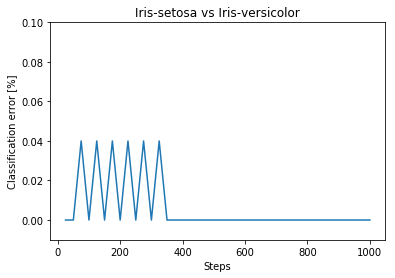

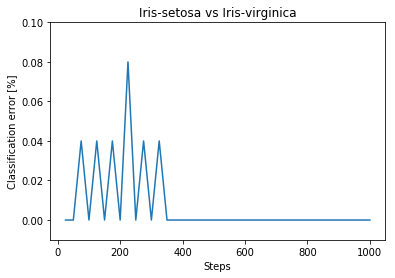

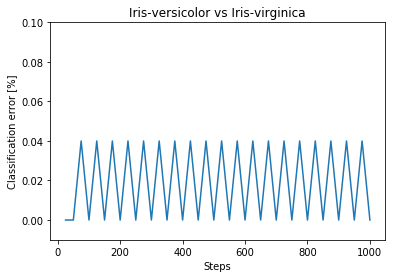

In [13]:
import itertools
from matplotlib import pyplot

for class_combination in itertools.combinations(np.unique(classes), 2):
    run_classes(class_combination)

setosa is linearly separable from the other two classes (perceptron converges).

versicolor and virginica are not linearly separable, the perceptron never converges

### Impact of learning rate

we only consider Iris-setosa vs Iris-versicolor.

Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


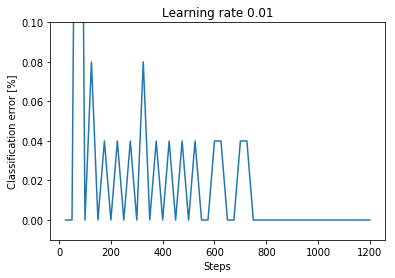

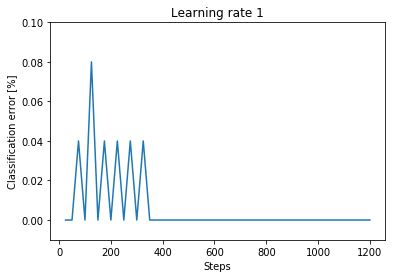

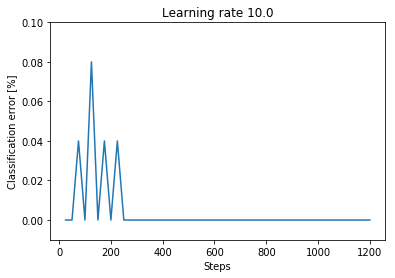

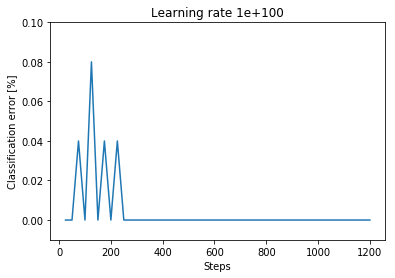

In [35]:
for learning_rate in [1e-2, 1, 1e1, 1e100]:
    run_classes(["Iris-setosa", "Iris-versicolor"], learning_rate=learning_rate, num_epochs=12)
    pyplot.title("Learning rate {}".format(learning_rate))

when the learning rate is too small, it takes a long time to converge because each update is just a tiny nudge in the right direction.

A large learning rate on the other hand leads to faster convergence at the possible price of missing the minima (this did not occur here, I guess we were lucky).